## 人名分类问题：
- 以一个人名为输入，使用模型帮助我们判断它最有可能是来自哪一个国家的人名，这在某些国际化公司的业务中具有重要意义，在用户注册过程中，会根据用户填写的名字直接给他分配可能的国家或地区选项，以及该国家或地区的国旗，限制手机号吗位数等等

## 整个案例分为5个步骤
- 第一步：导入必要的工具包
- 第二步: 对data文件中的数据进行处理，满足训练要求
- 第三步: 构建RNN模型(包括传统的RNN,LSTM以及GRU等)
- 第四步：构建训练函数并进行训练
- 第五步：构建评估函数并进行预测

In [1]:
#  第一步：导入必要的工具包
from io import open
import glob
import os

import string
import unicodedata

import random
import time
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from nltk.parse import evaluate
from pygments.lexers import math

# 第二步：对data文件中的数据进行处理，满足训练要求
# 获取所有的常用字符包括字母和常用标点
all_letters = string.ascii_letters + " .,;'"
# 获取常用字符数量
n_letters = len(all_letters)
print("n_letter:", n_letters)
print("all_letters:", all_letters)

n_letter: 57
all_letters: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


#### 字符规范之unicode转Ascii函数

In [2]:
# 关于编码问题我们暂且不去考虑
# 这个函数的作用就是去掉一些语言中的重音标记
# 如: Ślusàrski ---> Slusarski
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
# 调用
s = "Ślusàrski"
a = unicodeToAscii(s)
print(a)


Slusarski


In [4]:
# 构建一个从持久化文件中读取内容到内存的函数
data_path = "./data/names/"

def readLines(filename):
    """从文件中读取每一行加载到内存中形成列表"""
    # 打开指定文件并读取所有内容, 使用strip()去除两侧空白符, 然后以'\n'进行切分
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    # 对应每一个lines列表中的名字进行Ascii转换, 使其规范化.最后返回一个名字列表
    return [unicodeToAscii(line) for line in lines]

# filename是数据集中某个具体的文件, 我们这里选择Chinese.txt
filename = data_path + "Chinese.txt"
lines = readLines(filename)
print(lines)

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao', 'Cen', 'Chai', 'Chaim', 'Chan', 'Chang', 'Chao', 'Che', 'Chen', 'Cheng', 'Cheung', 'Chew', 'Chieu', 'Chin', 'Chong', 'Chou', 'Chu', 'Cui', 'Dai', 'Deng', 'Ding', 'Dong', 'Dou', 'Duan', 'Eng', 'Fan', 'Fei', 'Feng', 'Foong', 'Fung', 'Gan', 'Gauk', 'Geng', 'Gim', 'Gok', 'Gong', 'Guan', 'Guang', 'Guo', 'Gwock', 'Han', 'Hang', 'Hao', 'Hew', 'Hiu', 'Hong', 'Hor', 'Hsiao', 'Hua', 'Huan', 'Huang', 'Hui', 'Huie', 'Huo', 'Jia', 'Jiang', 'Jin', 'Jing', 'Joe', 'Kang', 'Kau', 'Khoo', 'Khu', 'Kong', 'Koo', 'Kwan', 'Kwei', 'Kwong', 'Lai', 'Lam', 'Lang', 'Lau', 'Law', 'Lew', 'Lian', 'Liao', 'Lim', 'Lin', 'Ling', 'Liu', 'Loh', 'Long', 'Loong', 'Luo', 'Mah', 'Mai', 'Mak', 'Mao', 'Mar', 'Mei', 'Meng', 'Miao', 'Min', 'Ming', 'Moy', 'Mui', 'Nie', 'Niu', 'OuYang', 'OwYang', 'Pan', 'Pang', 'Pei', 'Peng', 'Ping', 'Qian', 'Qin', 'Qiu', 'Quan', 'Que', 'Ran', 'Rao', 'Rong', 'Ruan', 'Sam', 'Seah', 'See ', 'Seow', 'Seto', 'Sha', 'Shan', 'Sh

#### 构建人名类别(所属的语言)列表和人名对应关系字典

In [5]:
# 构建的category_lines形如：{"English":["Lily", "Susan", "Kobe"], "Chinese":["Zhang San", "Xiao Ming"]}
category_lines = {}
# all_categories形如： ["English",...,"Chinese"]
all_categories = []

# 读取指定路径下的txt文件，使用glob,path中可以使用正则表达式
for filename in glob.glob(data_path + "*.txt"):
    # 获取每个文件的文件名，就是对应的名字类别
    category = os.path.splitext(os.path.basename(filename))[0]
    # 将其逐一加到all_categories列表中
    all_categories.append(category)
    # 然后读取每个文件的内容，形成名字列表
    lines = readLines(filename)
    # 按照对应的类别，将名字列表写入到catagory_lines字典中
    category_lines[category] = lines

# 查看类别总数
n_categories = len(all_categories)
print("n_categories:", n_categories)

n_categories: 18


In [6]:
# 随便查看其中的一些内容
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [7]:
# 将人名转化为对应的one-hot张量表示
# 将字符串(单词粒度)转化为张量表示，如："ab" --->
# tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#          0., 0., 0., 0., 0., 0.]],

#        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#          0., 0., 0., 0., 0., 0.]]])
def lineToTensor(line):
    """将人名转化为对应的one-hot张量表示，参数line是输入的人名"""
    # 首先初始化一个0张量，它的形状(len(line), 1, n_letters)
    # 代表人名中的每个字母用一个1 x n_letters的张量表示
    tensor = torch.zeros(len(line), 1, n_letters)
    # 遍历这个人名中的每个字符索引和字符
    for li, letter in enumerate(line):
        # 使用字符串方法find找到每个字符在all_letters中的索引
        # 它也是我们生成one-hot张量中1的索引位置
        tensor[li][0][all_letters.find(letter)] = 1
    # 返回结果
    return  tensor


line = "Bai"
line_tensor = lineToTensor(line)
print("line_tensor:", line_tensor)

line_tensor: tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])


In [8]:
# 构建传统RNN模型
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        """初始化函数中有4个参数，分别代表RNN输入最后一维尺寸，RNN隐层最后一维尺寸,RNN层数"""
        # input_size:代表RNN输入的最后一个维度
        # hidden_size:代表RNN隐藏层的最后一个维度
        # output_size:代表RNN网络最后线性层的输出维度
        # num_layers:代表RNN网络的层数
        super(RNN, self).__init__()
        # 将hidden_size与num_layers传入其中
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 实例化预定义的nn.RNN,它的三个参数分别是input_size，hidden_size, num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers)
        # 实例化nn.Linear,这个线性层用于将nn.RNN的输出值维度转化为指定的输出维度
        self.linear = nn.Linear(hidden_size, output_size)
        # 实例化nn中预定的Softmax层，用于从输出层获得类别结果
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, input, hidden):
        """完成传统RNN的主要逻辑，输入参数input代表输入张量，它的形状是1 x n_letters
        hidden代表RNN的隐层张量，它的形状是self.num_layers x 1 x self.hidden_size"""
        # 因此预定义的nn.RNN要求输入维度一定是三维张量，因此在这里使用unsqueeze(0)扩展一个维度
        input = input.unsqueeze(0)
        # 将input和hidden输入到传统RNN的实例化对象中，如果num_layers = 1，rr恒等于hn
        rr, hn = self.rnn(input, hidden)
        # 将从RNN中获得的结果通过线性变换和softmax返回，同时返回hn作为后续RNN的输入
        return self.softmax(self.linear(rr)), hn

    def initHidden(self):
        """初始化隐层张量"""
        # 初始化一个(self.num_layers, 1, self.hidden_size)形状为0的张量
        return torch.zeros(self.num_layers, 1, self.hidden_size)

In [16]:
# torch.unsqueeze演示
x = torch.tensor([1, 2, 3, 4])
print(x.shape)
z = torch.unsqueeze(x, 0)
print(z.shape)

torch.Size([4])
torch.Size([1, 4])


In [17]:
y = torch.unsqueeze(x, 1)
print(y.shape)

torch.Size([4, 1])


In [11]:
# 构建LSTM模型
# 使用nn.LSTM构建完成LSTM使用类
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        # 初始化函数的参数与传统RNN相同
        super(LSTM, self).__init__()
        # 将hidden_size与num_layers传入其中
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 实例化预定义的nn.LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        # 实例化nn.Linear,这个线性层用于将nn.LSTM的输出维度转化为指定的输出维度
        self.linear = nn.Linear(hidden_size, output_size)
        # 实例化nn中预定的Softmax层，用于从输出层获得类别结果
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, input, hidden, c):
        """在主要逻辑函数中多出一个参数c, 也就是LSTM中的细胞状态张量"""
        # 使用unsqueeze(0)扩展一个维度
        input = input.unsqueeze(0)
        # 将input, hidden以及初始化的c传入lstm中
        rr, (hn, c) = self.lstm(input, (hidden, c))
        # 最后返回处理后rr, hn, c
        return self.softmax(self.linear(rr)), hn, c

    def initHiddenAndC(self):
        """初始化函数不仅初始化hidden还要初始化细胞状态c，它们的形状相同"""
        c = hidden = torch.zeros(self.num_layers, 1, self.hidden_size)
        return  hidden, c

In [12]:
# 构建GRU模型
# 使用nn.GRU构建完成传统RNN使用类

# GRU与传统RNN的外部形式相同, 都是只传递隐层张量, 因此只需要更改预定义层的名字
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 实例化预定义的nn.GRU, 它的三个参数分别是input_size, hidden_size, num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, input, hidden):
        input = input.unsqueeze(0)
        rr, hn = self.gru(input, hidden)
        return self.softmax(self.linear(rr)), hn

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size)

#### 实例化参数

In [26]:
# 因为是onehot编码, 输入张量最后一维的尺寸就是n_letters
input_size = n_letters

# 定义隐层的最后一维尺寸大小
n_hidden = 57

# 输出尺寸为语言类别总数n_categories
output_size = n_categories

# num_layer使用默认值, num_layers = 1

#### 输入参数

In [27]:
# 假如我们以一个字母B作为RNN的首次输入, 它通过lineToTensor转为张量
# 因为我们的lineToTensor输出是三维张量, 而RNN类需要的二维张量
# 因此需要使用squeeze(0)降低一个维度
input = lineToTensor('B').squeeze(0)

# 初始化一个三维的隐层0张量, 也是初始的细胞状态张量
hidden = c = torch.zeros(1, 1, n_hidden)

#### 调用

In [29]:
rnn = RNN(n_letters, n_hidden, n_categories)
lstm = LSTM(n_letters, n_hidden, n_categories)
gru = GRU(n_letters, n_hidden, n_categories)

rnn_output, next_hidden = rnn(input, hidden)
print("rnn:", rnn_output)
print("rnn.shape:", rnn_output.shape)
lstm_output, next_hidden, c = lstm(input, hidden, c)
print("lstm:", lstm_output)
print("lstm.shape:", lstm_output.shape)
gru_output, next_hidden = gru(input, hidden)
print("gru:", gru_output)
print("gru.shape:", gru_output.shape)

rnn: tensor([[[-2.9879, -3.1140, -2.9302, -2.8892, -3.0818, -2.7007, -2.6251,
          -2.8833, -2.8417, -2.9852, -2.9925, -3.0889, -2.9286, -2.7733,
          -2.7649, -2.8631, -2.9344, -2.7964]]], grad_fn=<LogSoftmaxBackward0>)
rnn.shape: torch.Size([1, 1, 18])
lstm: tensor([[[-2.9077, -2.7731, -2.9073, -2.9322, -2.9242, -2.9533, -2.8012,
          -2.7922, -2.7910, -2.8518, -2.9046, -3.0164, -2.9827, -2.9458,
          -2.9559, -2.7684, -2.8808, -2.9921]]], grad_fn=<LogSoftmaxBackward0>)
lstm.shape: torch.Size([1, 1, 18])
gru: tensor([[[-2.7727, -2.7887, -2.9656, -2.9033, -2.9723, -2.9675, -2.8865,
          -2.7472, -2.9438, -2.8640, -3.0225, -2.8290, -3.0852, -2.9195,
          -2.8837, -2.7212, -2.9279, -2.9047]]], grad_fn=<LogSoftmaxBackward0>)
gru.shape: torch.Size([1, 1, 18])


#### 第四步：构建训练函数并进行训练

In [30]:
# 从输出结果中获得指定类别的函数

def categoryFromOutput(output):
    """从输出结果中获得指定类别，参数为输出张量output"""
    # 从输出张量中返回最大的值和索引，作为我们的类别信息，我们这里主要需要这个索引
    top_n, top_i = output.topk(1)
    # top_i对象中取出索引的值
    category_i = top_i[0].item()
    # 根据索引获得对应语言类型，返回语言类别和索引值
    return all_categories[category_i], category_i

In [33]:
# torch.topk演示
x = torch.arange(1., 6.)
print(x)
z = torch.topk(x, 3)
print(z)

tensor([1., 2., 3., 4., 5.])
torch.return_types.topk(
values=tensor([5., 4., 3.]),
indices=tensor([4, 3, 2]))


In [34]:
# 输入参数
# 将上一步中grur的输出作为函数的输入
output = gru_output
# 调用
category, category_i = categoryFromOutput(output)
print("category:", category)
print("category_i:", category_i)

category: Dutch
category_i: 15


### 随机生成训练数据

In [54]:
def randomTrainingExample():
    """该函数用于随机产生训练数据"""
    # 首先使用random的choice方法从all_categories随机选择一个类别
    category = random.choice(all_categories)
    # 然后再通过category_lines字典取category类别对应的名字列表
    # 之后再从列表中随机取一个名字
    line = random.choice(category_lines[category])
    # 接着将这个类别在所有类别列表中的索引封装成tensor,得到类别张量category_tensor
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    # 最后，将随机取到的名字通过函数lineToTensor转化为onehot张量表示
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [60]:
# 我们随机取出十个进行结果查看
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line, '/ category_tensor =', category_tensor, '/ category_tensor.dim =', category_tensor.dim(), ' / line_tensor.size =', line_tensor.size())

category = Polish / line = Slazak / category_tensor = tensor([17]) / category_tensor.dim = 1  / line_tensor.size = torch.Size([6, 1, 57])
category = Irish / line = Madaidhin / category_tensor = tensor([8]) / category_tensor.dim = 1  / line_tensor.size = torch.Size([9, 1, 57])
category = English / line = Girling / category_tensor = tensor([9]) / category_tensor.dim = 1  / line_tensor.size = torch.Size([7, 1, 57])
category = Russian / line = Gordusenko / category_tensor = tensor([6]) / category_tensor.dim = 1  / line_tensor.size = torch.Size([10, 1, 57])
category = Irish / line = Reagan / category_tensor = tensor([8]) / category_tensor.dim = 1  / line_tensor.size = torch.Size([6, 1, 57])
category = French / line = Descoteaux / category_tensor = tensor([7]) / category_tensor.dim = 1  / line_tensor.size = torch.Size([10, 1, 57])
category = Arabic / line = Dagher / category_tensor = tensor([2]) / category_tensor.dim = 1  / line_tensor.size = torch.Size([6, 1, 57])
category = Portuguese / li

#### 构建传统RNN训练函数

In [72]:
# 定义损失函数为nn.NLLLoss，因为RNN的最后一层是nn.LogSoftmax,两者的内部计算逻辑正好能够吻合
criterion = nn.NLLLoss()

# 设置学习率
learning_rate = 0.005

def trainRNN(category_tensor, line_tensor):
    """定义训练函数，它的两个参数是category_tensor类别的张量表示，相当于训练数据的标签
    line_tensor名字张量的表示，相当于对应训练数据"""
    # 在函数中，首先通过实例化对象rnn初始化隐层张量
    hidden = rnn.initHidden()
    # 然后将模型结构中的梯度归0
    rnn.zero_grad()

    # 下面开始进行训练，将训练数据line_tensor的每个字符逐个传入rnn之中，得到最终结果
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    # 因为我们的rnn对象由nn.RNN实例化得到，最终输出形状是三维张量，为了满足于category_tensor
    # 进行对比计算损失, 需要减少第一个维度, 这里使用squeeze()方法
    loss = criterion(output.squeeze(0), category_tensor)

    # 损失进行反向传播
    loss.backward()
    # 更新模型中所有的参数
    for p in rnn.parameters():
        # 将参数的张量表示与参数的梯度乘以学习率的结果相加以此来更新参数
        p.data.add_(-learning_rate, p.grad.data)
    # 返回结果和损失的值
    return output, loss.item()

In [68]:
# torch.squeeze
a = torch.randn(1,2,3)
print(a)
c = a.squeeze(0) # 这个是降维的操作
print(c)

tensor([[[-0.2849, -1.0164,  0.7642],
         [ 0.4739,  1.3522, -0.6468]]])
tensor([[-0.2849, -1.0164,  0.7642],
        [ 0.4739,  1.3522, -0.6468]])


In [41]:
# torch.add演示
a = torch.randn(4)
print(a)

b = torch.randn(4, 1)
print(b)
torch.add(a, b, alpha=10)

tensor([-0.7177, -0.3273, -0.4882,  0.3834])
tensor([[ 1.6106],
        [-0.8278],
        [ 0.1480],
        [ 1.2159]])


tensor([[15.3880, 15.7784, 15.6174, 16.4891],
        [-8.9953, -8.6049, -8.7659, -7.8943],
        [ 0.7623,  1.1527,  0.9917,  1.8633],
        [11.4410, 11.8314, 11.6705, 12.5421]])

#### 构建LSTM训练函数

In [42]:
# 与传统RNN相比多了一个细胞状态c
def trainLSTM(category_tensor, line_tensor):
    hidden, c = lstm.initHiddenAndC()
    lstm.zero_grad()
    for i in range(line_tensor.size()[0]):
        # 返回output, hidden以及细胞状态c
        output, hidden, c = lstm(line_tensor[i], hidden, c)
    loss = criterion(output.squeeze(0), category_tensor)
    loss.backward()

    for p in lstm.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    return output, loss.item()

#### 构建GRU训练函数

In [77]:
# 与传统RNN完全相同，只不过名字改成了GRU
def trainGRU(categoory_tensor, line_tensor):
    hidden = gru.initHidden()
    gru.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)
    loss = criterion(output.squeeze(0), categoory_tensor)
    loss.backward()

    for p in gru.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    return output, loss.item()

#### 构建时间计算函数

In [49]:
import math
def timeSince(since):
    """获得每次打印的训练耗时，since是训练开始时间"""
    # 获得当前时间
    now = time.time()
    # 获得时间差，就是训练耗时
    s = now - since
    # 将秒转化为分钟，并取整
    m = math.floor(s / 60)
    # 计算剩下不够凑成一分钟的秒数
    s -= m * 60
    # 返回指定格式的耗时
    return '%dm %ds' % (m, s)

In [50]:
# 假定模型训练开始时间是10min之前
since = time.time() - 10*60
period = timeSince(since)
print(period)

10m 0s


#### 构建训练过程的日志打印函数

In [70]:
# 设置训练迭代次数
n_iters = 1000
# 设置结果的打印间隔
print_every = 50
# 设置绘制损失曲线上的制图间隔
plot_every = 10

def train(train_type_fn):
    """训练过程的日志打印函数，参数train_type_fn代表选择哪种模型训练函数，如trainRNN"""
    # 第个制图间隔损失保存列表
    all_losses = []
    # 获得开始训练的时间戳
    start = time.time()
    # 设置初始间隔损失为0
    current_loss = 0
    # 从1开始进行训练迭代，共n_iters次
    for iter in range(1, n_iters+1):
        # 通过randomTrainingExample函数随机获取一组训练数据和对应的类别
        category, line, category_tensor, line_tensor = randomTrainingExample()
        # 将训练数据和对应类别的张量表示传入到train函数中
        output, loss = train_type_fn(category_tensor, line_tensor)
        # 计算制图间隔中的总损失
        current_loss += loss
        # 如果迭代数能够整除打印间隔
        if iter % print_every == 0:
            # 取该次迭代步上的output通过categoryFromOutput函数获取对应的类别和类别索引
            guess, guess_i = categoryFromOutput(output)
            # 然后和真实的类别category做比较，如果相同则打对号，否则打叉号
            correct = '✓' if guess == category else '✗ (%s)' % category
            # 打印迭代步，迭代步百分比，当前训练耗时，损失，该步预测的名字，以及是否正确
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        # 如果迭代数能够整除制图间隔
        if iter % plot_every == 0:
            # 将保存该间隔中的平均损失到all_losses列表中
            all_losses.append(current_loss / plot_every)
            # 间隔损失重置为0
            current_loss = 0
    # 返回对应瓣总损失列表和训练耗时
    return all_losses, int(time.time() - start)

50 5% (0m 0s) 2.6449 Minnibaev / Vietnamese ✗ (Russian)
100 10% (0m 0s) 2.9269 Symes / Greek ✗ (English)
150 15% (0m 0s) 2.9472 Leonard / Vietnamese ✗ (English)
200 20% (0m 0s) 3.0143 Crawford / German ✗ (Scottish)
250 25% (0m 0s) 2.6275 Holzmann / German ✓
300 30% (0m 0s) 2.8623 Keay / German ✗ (English)
350 35% (0m 0s) 2.8444 Zavala / German ✗ (Spanish)
400 40% (0m 0s) 2.3821 Bekhteev / Russian ✓
450 45% (0m 0s) 2.7166 Essa / Russian ✗ (Arabic)
500 50% (0m 1s) 2.9463 Mah / Vietnamese ✗ (Chinese)
550 55% (0m 1s) 2.8294 Titmus / Greek ✗ (English)
600 60% (0m 1s) 2.5439 Thao / Vietnamese ✓
650 65% (0m 1s) 2.7876 Santos / Greek ✗ (Spanish)
700 70% (0m 1s) 2.8050 Hay / Vietnamese ✗ (Scottish)
750 75% (0m 1s) 2.6136 Oelberg / English ✗ (German)
800 80% (0m 1s) 2.9270 Kijek / Vietnamese ✗ (Polish)
850 85% (0m 1s) 2.4670 Bicchieri / Polish ✗ (Italian)
900 90% (0m 2s) 2.7490 Fierro / Italian ✗ (Spanish)
950 95% (0m 2s) 2.4866 Vaisman / Irish ✗ (Russian)
1000 100% (0m 2s) 2.9172 Aldworth / Rus

<BarContainer object of 3 artists>

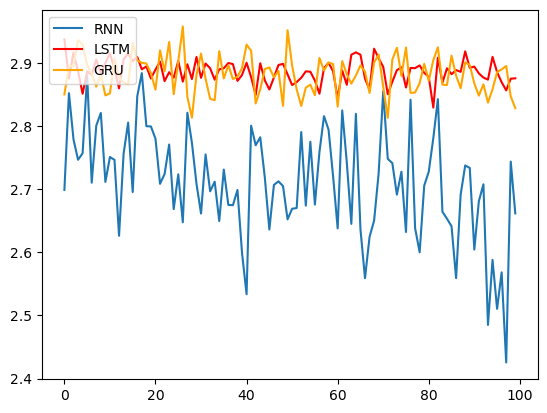

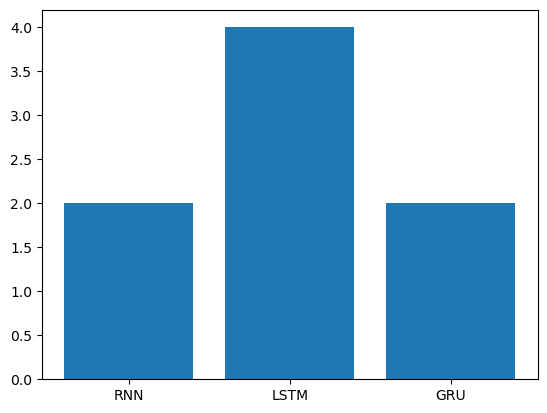

In [79]:
# 调用train函数, 分别进行RNN, LSTM, GRU模型的训练
# 并返回各自的全部损失, 以及训练耗时用于制图
all_losses1, period1 = train(trainRNN)
all_losses2, period2 = train(trainLSTM)
all_losses3, period3 = train(trainGRU)

# 绘制损失对比曲线，训练耗时对比柱状图
# 创建画布0
plt.figure(0)
# 绘制损失对比曲线
plt.plot(all_losses1, label="RNN")
plt.plot(all_losses2, color="red", label="LSTM")
plt.plot(all_losses3, color="orange", label="GRU")
plt.legend(loc="upper left")

# 创建画布1
plt.figure(1)
x_data = ['RNN', 'LSTM', 'GRU']
y_data = [period1, period2, period3]

# 绘制训练耗时对比柱状图
plt.bar(range(len(x_data)), y_data, tick_label=x_data)

#### 损失曲线对比
- 模型训练的损失降低快慢代表模型收敛程度，由图可知，传统RNN模型收敛情况最好，然后是GRU，最后是LSTM，这是因为，我们当前处理的文本数据是人名，他们的长度有限，且长距率字母间基本无特定关联，因此无法发挥改进模型LSTM和GRU的长距离捕捉语义关联的优势，所以在以后的模型选用时，要通过对任务的分析以及实验对比，选择最适合的模型
#### 训练耗时对比图分析
- 模型训练的耗时长短代表模型的计算复杂度, 由图可知, 也正如我们之前的理论分析, 传统RNN复杂度最低, 耗时几乎只是后两者的一半, 然后是GRU, 最后是复杂度最高的LSTM.
#### 结论:
- 模型选用一般应通过实验对比, 并非越复杂或越先进的模型表现越好, 而是需要结合自己的特定任务, 从对数据的分析和实验结果中获得最佳答案.

#### 第五步：构建评估函数并进行预测

In [88]:
# 构建传统RNN评估函数
def evaluateRNN(line_tensor):
    """评估函数，和训练函数逻辑相同，参数是line_tensor代表名字和张量表示"""
    # 初始化隐层张量
    hidden = rnn.initHidden()
    # 将评估数据line_tensor的每个字符逐个传入RNN中
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    # 获得输出结果
    print("RNN output.dim", output.dim())
    return output.squeeze(0)

In [92]:
# 构建LSTM评估函数
def evaluateLSTM(line_tensor):
    # 初始化隐层张量和细胞状态张量
    hidden, c = lstm.initHiddenAndC()
    # 将评估数据line_tensor的每个字符逐个传入lstm中
    for i in range(line_tensor.size()[0]):
        output, hidden, c = lstm(line_tensor[i], hidden, c)
    print("LSTM output.dim", output.dim())
    return  output.squeeze(0)

In [94]:
# 构建GRU评估函数
def evaluateGRU(line_tensor):
    # 初始化隐层张量和细胞状态张量
    hidden = gru.initHidden()
    # 将评估数据line_tensor的每个字符逐个传入gru中
    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)
    print("GRU output.dim", output.dim())
    return  output.squeeze(0)

In [95]:
lien = "Bai"
line_tensor = lineToTensor(line)

rnn_output = evaluateRNN(line_tensor)
lstm_output = evaluateLSTM(line_tensor)
gru_output = evaluateGRU(line_tensor)

print("rnn_output:", rnn_output)
print("gru_output:", lstm_output)
print("gru_output:", gru_output)

RNN output.dim 3
LSTM output.dim 3
GRU output.dim 3
rnn_output: tensor([[-3.1873, -2.8925, -3.0172, -2.9641, -3.8738, -3.7850, -2.0870, -3.0356,
         -2.4690, -2.5353, -3.1307, -2.7385, -3.0898, -3.1616, -2.5030, -2.8420,
         -3.7076, -2.7756]], grad_fn=<SqueezeBackward1>)
gru_output: tensor([[-2.8592, -2.7981, -2.7322, -3.0152, -2.9753, -2.9411, -2.8643, -2.8726,
         -2.9117, -2.8424, -2.9043, -2.9691, -2.9397, -2.8454, -2.9544, -2.8811,
         -2.9243, -2.8379]], grad_fn=<SqueezeBackward1>)
gru_output: tensor([[-2.8288, -2.8651, -2.8819, -3.0142, -2.9718, -3.0885, -2.7484, -2.8883,
         -2.8754, -2.9921, -2.8150, -2.8679, -2.8575, -2.7981, -2.9420, -2.8192,
         -2.8537, -2.9824]], grad_fn=<SqueezeBackward1>)


#### 构建预测函数

In [97]:
def predict(input_line, evaluate, n_predictions=3):
    """预测函数，输入参数input_line代表输入的名字,
    n_predictions代表需要取最有可能的top个"""
    # 首先打印输入
    print('\n> %s' % input_line)

    # 以下操作的相关张量不进行求梯度
    with torch.no_grad():
        # 使输入的名字转换为张量表示，并使用evaluate函数获得预测输出
        output = evaluate(lineToTensor(input_line))

        # 从预测的输出中取前3个最大的值及其索引
        topv, topi = output.topk(n_predictions, 1, True)
        # 创建预测结果列表
        predictions = []
        # 遍历n_predictions
        for i in range(n_predictions):
            # 从topv中取出output值
            value = topv[0][i].item()
            # 取出索引并找到对应的类别
            category_index = topi[0][i].item()
            # 打印ouput的值, 和对应的类别
            print('(%.2f) %s' % (value, all_categories[category_index]))
            # 将结果装进predictions中
            predictions.append([value, all_categories[category_index]])

In [98]:
for evaluate_fn in [evaluateRNN, evaluateLSTM, evaluateGRU]:
    print("-"*18)
    predict('Dovesky', evaluate_fn)
    predict('Jackson', evaluate_fn)
    predict('Satoshi', evaluate_fn)

------------------

> Dovesky
RNN output.dim 3
(-2.06) Russian
(-2.40) Polish
(-2.54) Greek

> Jackson
RNN output.dim 3
(-2.06) Russian
(-2.49) Scottish
(-2.50) Irish

> Satoshi
RNN output.dim 3
(-2.33) Russian
(-2.35) Polish
(-2.51) Italian
------------------

> Dovesky
LSTM output.dim 3
(-2.72) Arabic
(-2.83) German
(-2.83) English

> Jackson
LSTM output.dim 3
(-2.73) Arabic
(-2.80) German
(-2.83) Polish

> Satoshi
LSTM output.dim 3
(-2.73) Arabic
(-2.83) German
(-2.83) Polish
------------------

> Dovesky
GRU output.dim 3
(-2.76) Russian
(-2.79) Spanish
(-2.80) Czech

> Jackson
GRU output.dim 3
(-2.75) Russian
(-2.81) Portuguese
(-2.82) Czech

> Satoshi
GRU output.dim 3
(-2.77) Russian
(-2.79) Spanish
(-2.79) Italian
